In [1]:
print("Hello world")

In [2]:
import os
import tarfile
import urllib
import ssl

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# https://stackoverflow.com/questions/27835619/urllib-and-ssl-certificate-verify-failed-error
ssl._create_default_https_context = ssl._create_unverified_context

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


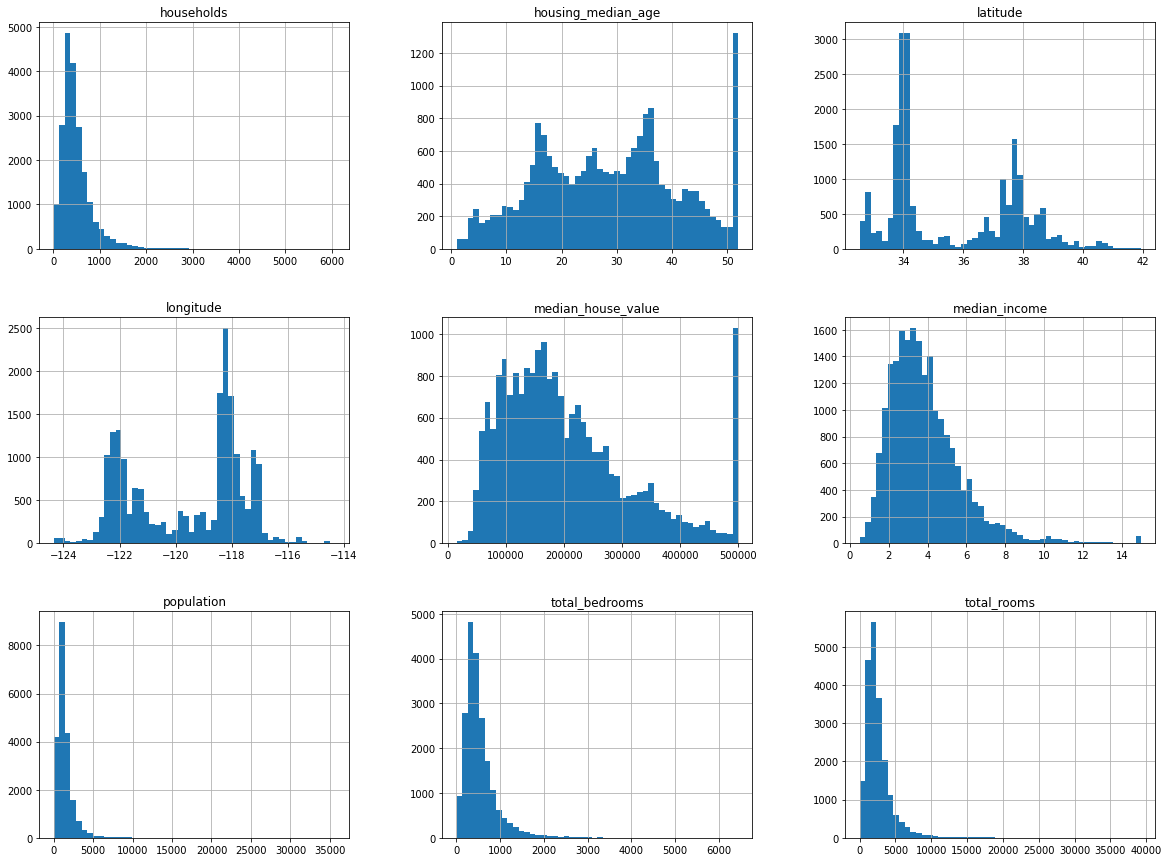

In [9]:
# only in a juypter notebook
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
import numpy as np

def split_train_test(dataset, test_ratio):
    shuffled_indices = np.random.permutation(len(dataset))
    test_size = int(len(dataset) * test_ratio)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return dataset.iloc[train_indices], dataset.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)

In [11]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
# To ensure the test set always contians the same elements in our data set, we add a unique id made up of a constant 
# features (such as lat/lng). Using an index for each observation alone would be enough,
# except that we would not be guaranteed to get the same observations if the data set changed and new data was not 
# appended to the end, OR if any of our previous data was deleted. Either of these scenarios cause a "shift" in the
# data that could return a drastically different test set. For these reasons, we opt for the below approach in
# generating a unique ID for each observation.
housing_with_id = housing.copy()
housing_with_id["id"] = housing_with_id["longitude"] * 1000 + housing_with_id["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

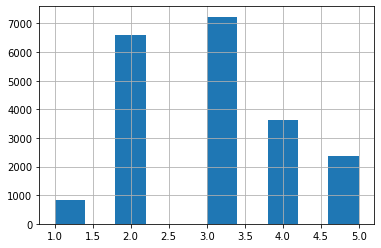

In [13]:
# From the book: 
# When a survey company decides to call 1,000 people to ask them a few questions, they don’t just pick 1,000 people
# randomly in a phone book. They try to ensure that these 1,000 people are representative of the whole population. 
# For example, the US population is 51.3% females and 48.7% males, so a well-conducted survey in the US would try to 
# maintain this ratio in the sample: 513 female and 487 male. This is called stratified sampling: the population is 
# divided into homogeneous subgroups called strata, and the right number of instances are sampled from each stratum 
# to guarantee that the test set is representative of the overall population. If the people running the survey used 
# purely random sampling, there would be about a 12% chance of sampling a skewed test set that was either less than 
# 49% female or more than 54% female. Either way, the survey results would be significantly biased.

# To combat this in our test set, we're observing the median income of a district, which we assume has a high
# correlation with average housing prices in that district.

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# We first create bins / categories of each income band (using our data to ensure each band has significant samples)

housing["income_cat"].hist()

In [14]:
# We can now use Scikitlearn's StratifiedShuffleSplit to get a test set that is distributed around a particular
# feature in the same way that our data is. From the output of the histogram above, we see that we should get a test
# set that comprises more of districts with an income_cat of 3 than any other income category. Likewise, we should see
# minimal observations that have an income_cat of 1 or 5.

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [15]:
# Now we can remove the income_cat feature from our datasets (train and test), since we won't be using it as a feature.

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [16]:
# ***Discover and visualize data to gain insights*** 

# Two quick thoughts here:
#    We don't want to explore the test set, for risk of seeing patterns that may lead us to build a model that overfits
#    To protect our real data, we'll make a copy of it first, just in case!

visualize_set = strat_train_set.copy()

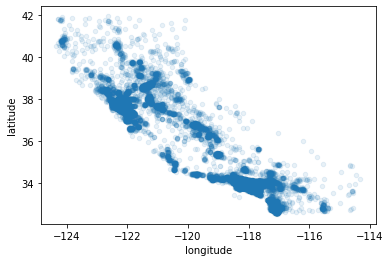

In [17]:
# Our first visualization - a scatterplot of lat/lng feature. Note the alpha parameter. Without it, we would get 
# the same shape, but lose the desnsity information indicated by darker areas below

visualize_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

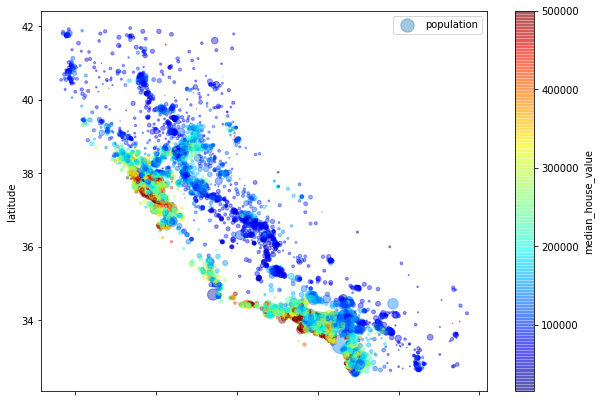

In [18]:
# Our second visualization will take aim at the housing prices on a similar scatterplot. To convey more information,
# the size of each circle is controlled by the 's' parameter, which we've mapped to population. Each circle is also
# colored, according to the median house value. The specific colors used are pre-defined in a colormap named "jet"

visualize_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=visualize_set["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

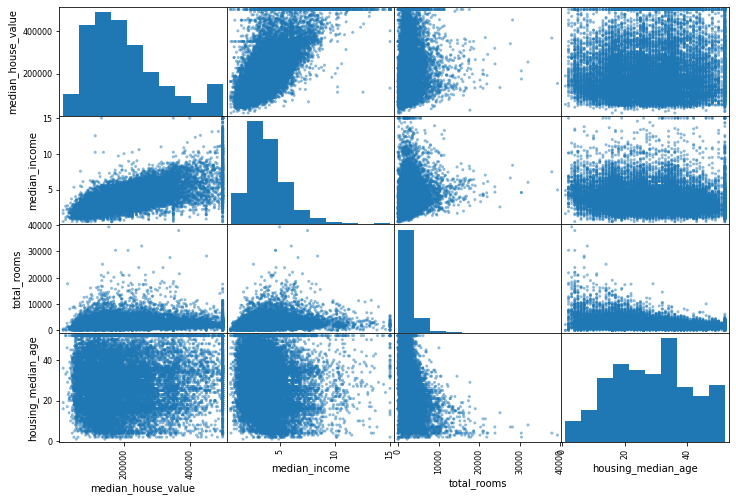

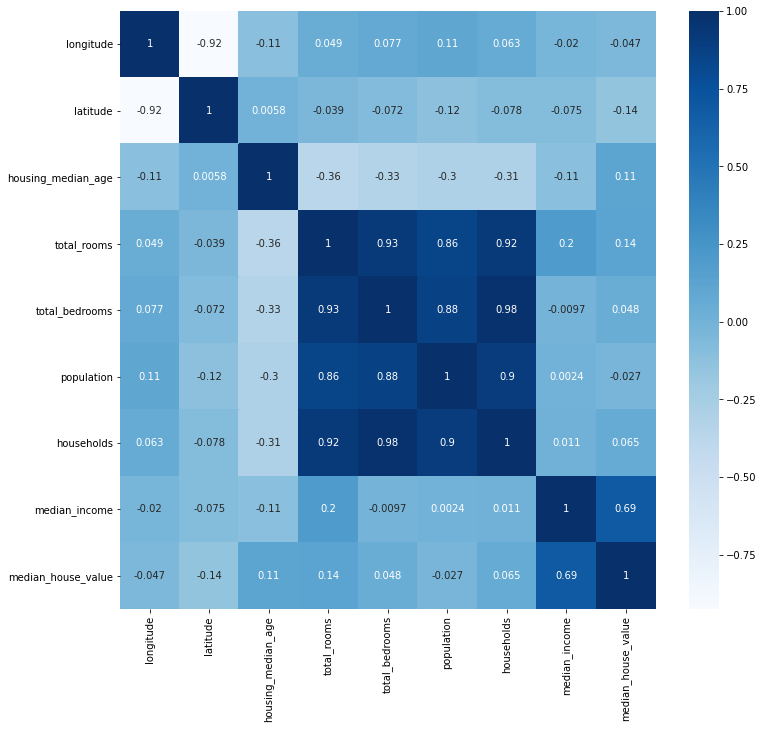

In [19]:
# The book gives some good ways to visualize each feature against one another to find correlations. The two mentioned
# are listed below

# Correlation Matrix
corr_matrix = visualize_set.corr()

# Scatter matrix for each feature pair (although here we only select 4 features)
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(visualize_set[attributes], figsize=(12, 8))

# However, I've seen some other heatmaps that I've really enjoyed, so below, I've tried to make one for our data.
import seaborn as sns; 
def visualize_corr(data):
    fig, ax = plt.subplots(figsize=(12,11))
    correlation = data.corr()
    sns.heatmap(correlation, annot=True, cbar=True, cmap="Blues", ax=ax)
    
visualize_corr(visualize_set)

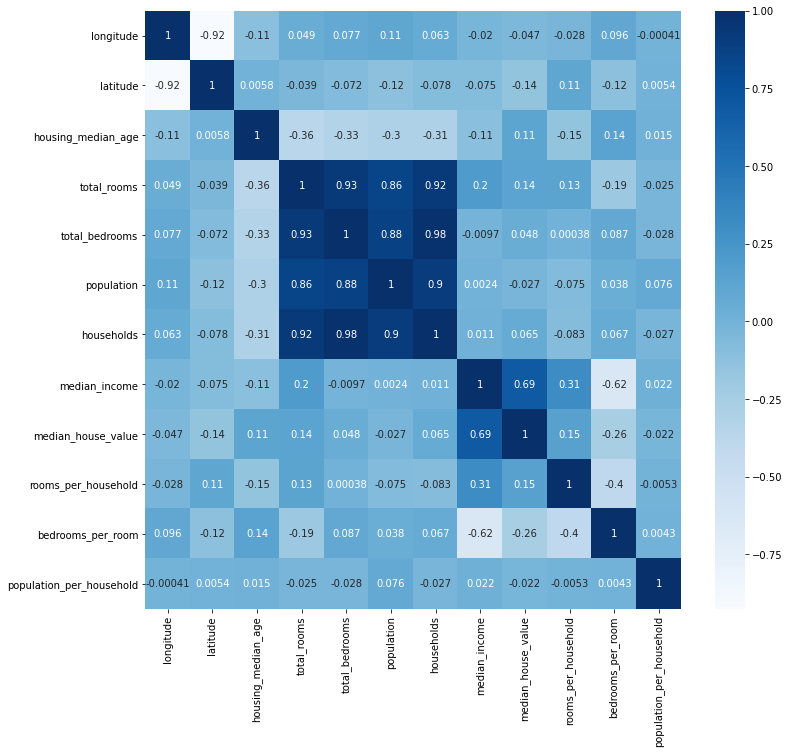

In [20]:
# Feature engineering
# For example, the total number of rooms in a district is not very useful if you don’t know how many households 
# there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by 
# itself is not very useful: you probably want to compare it to the number of rooms. And the population per household 
# also seems like an interesting attribute combination to look at. Let’s create these new attributes:

visualize_set["rooms_per_household"] = visualize_set["total_rooms"] / visualize_set["households"]
visualize_set["bedrooms_per_room"] = visualize_set["total_bedrooms"] / visualize_set["total_rooms"]
visualize_set["population_per_household"] = visualize_set["population"] / visualize_set["households"]

# Given these new features, it might make sense to view the correlation matrix again - to see if our engineered
# features have a strong correlation with house value.

visualize_corr(visualize_set)

# Looking at "Rooms per household" in comparison to the "Total Rooms" feature, we can see that it has a slightly
# stronger correlation in the data. More significantly, the ratio of bedrooms to rooms is much stronger than either
# the "Total Rooms" or the "Total Bedrooms" feature on their own.

In [21]:
# Now, we'll prepare the data for our model. This will include cleaning out bad data, handling null or empty values,
# and converting any categorical or textual features into numeric ones.

# As with the data set that we experimented on for visualizations, we'll make a copy of the data first.
clean_data = strat_train_set.drop("median_house_value", axis=1)
clean_data_labels = strat_train_set["median_house_value"].copy()

In [22]:
# First, let's take care of the missing data. We saw before (using the call below) that total_bedrooms has many
# missing values.
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [23]:
# We have three options to adress this:
# 1. Remove all instances that have a missing value
# 2. Remove the feature entirely
# 3. Attempt to fill in the missing values with our own estimate.
### clean_data.dropna(subset=["total_bedrooms"])    # option 1
### clean_data.drop("total_bedrooms", axis=1)       # option 2
### median = clean_data["total_bedrooms"].median()  # option 3
### clean_data["total_bedrooms"].fillna(median, inplace=True)

# Option 3 seems the most reasonable solution, since we have a significant amount of null values for that feature.
# But hang on - if we substitute out the empty values for the median like we do above, we'll need to do the same
# on our test set later. Because of this, we should save the median value calculated here, so we can adjust it later
# with the train set. Furthermore, it will be useful when we deploy our model and may want to handle a live scenario
# with more data coming in, possibly with null values.

# For this purpose, Scikit's Imputer is a good fit.
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# The imputer won't work on data sets with non-numeric features, so let's make a copy without "proximity_to_ocean"
housing_num = clean_data.drop("ocean_proximity", axis=1)

# And now we can fit our imputer, causing it to generate median values for each feature.
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [24]:
# Great! Now we've got all of our median values calculated with .fit(). We can apply these median values to any empty
# fields with .transform()
transformed_data = imputer.transform(housing_num) # As a note, there is a fit_transform() function that will do both.

# But this won't be returned as a PD dataframe. Instead, it's just an NP array. Let's put a dataframe back together:
housing_tr = pd.DataFrame(transformed_data, columns=housing_num.columns, index=housing_num.index)
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [25]:
# Time to sanitize the text features. We've only got one, ocean_proximity.
ocean_proximity = clean_data[["ocean_proximity"]]
ocean_proximity.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [26]:
# We can easily turn them into numeric representations like so:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(ocean_proximity)
housing_cat_encoded[:10]

# ...Which does indeed turn them into numbers, but will assign them values of 1-4. The difficulty here is that our
# model will assume that 1 & 2 are more closely related than a value of 1 & 4. However, we can see that the value
# assignment was arbitrary, and that values 0 & 4 are actually the most related!

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [27]:
# We can solve for this by structuring this data in a way that won't associate close numbers with some implied 
# measure of similarity. A good way to do this is one-hot encoding.
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(ocean_proximity)
housing_cat_1hot

# This is stored as a sparse matrix, but to view it in full, we can always call
housing_cat_1hot.toarray()
# .. and retrieve the corresponding values from
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [28]:
# Using the same fit & transform methods we used before, we can write our own transformers. Here's a simple one
# to handle a task we carried out earlier - adding the rooms_per_household, population_per_household, and
# bedrooms_per_rooms attribute. The feature_ix variables specified are the indicies of the features of which these
# new features are composed of. A construction parameter for add_bedrooms_per_room exists to easily toggle adding
# that feature to our dataset.
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room  
        
    def fit(self, X, y=None):
            return self  # nothing else to do  
        
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:            
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(clean_data.values)

In [29]:
# Onto the next issue - scaling. Machine learning algorithms perform better with small numbers centered near 0.
# With the notable exception of our target feature or label (median_house_value), we should look to scale our features

# Min-Max sclaing (normalization): values end up between 0 & 1. (my_feature - min) / (max - min).

# Standardization: values not guaranteed to be between 0 & 1 (my_feature - feature_mean) / standard_deviation.

# ScikitLearn provides utilities for both approaches - MinMaxScaler and StandardScaler.

# Below, we use the Standard Scaler, as detailed above, but we also introduce a new concept: a pipeline.
# A pipeline is an easy way to encapsulate numerous transformations or operations on a dataset. Below, we define one
# that consists of replacing the empty values within our data set (Imputer), adding the combined attributes, and
# finally scaling each feature. The final call to fit_transform on the pipeline will in turn call fit_transform
# on each of the individual steps.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()), 
        ('std_scaler', StandardScaler()),
    ])

# note that we're using our earlier housing_num that does not yet have these changes applied.
housing_num_tr = num_pipeline.fit_transform(housing_num) 

In [30]:
# Here's a second pipeline, which helps us solve the issue of previously having to deal with numeric and categorical
# values seperately. In this pipeline, we can specify which columns should be operated on by each estimator or step
# in the pipeline. Now we can utilize our previous numeric-only pipeline as a step in this final pipeline. And also
# handle our categorical attributes in the same pipeline!

from sklearn.compose import ColumnTransformer

numeric_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numeric_attribs),                                                                                        
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(clean_data)

In [31]:
# Finally, it is time to select and train our model!
from sklearn.linear_model import LinearRegression

housing_labels = clean_data_labels
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
# Let's check our regressor's accuracy on some of our data

some_data = clean_data.iloc[:5]
some_labels = clean_data_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions", lin_reg.predict(some_data_prepared))
print("Labels", list(some_labels))

Predictions [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [33]:
# We can see it's working, at least. But the accuracy isn't very good. We can evaluate the accuracy more effectively
# if we take a look at a metric that represents the error across the whole dataset. RMSE is one such metric for 
# computing loss.

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
mse = mean_squared_error(housing_predictions, clean_data_labels)
rmse = np.sqrt(mse)
rmse

68628.19819848922

In [34]:
# The output is 68628, or an average prediction error of $68,628. That's not very good, and is a sign that our model
# is underfitting the training data.

# "As we saw in the previous chapter, the main ways to fix underfitting are to select a more powerful model, to feed 
# the training algorithm with better features, or to reduce the constraints on the model."

# First, let's try a different model
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, clean_data_labels)

housing_predictions = tree_reg.predict(housing_prepared)
mse = mean_squared_error(housing_predictions, clean_data_labels)
rmse = np.sqrt(mse)
rmse

0.0

In [35]:
# Well, an average error of 0 isn't much better. If our model didn't make a single error, it's likely overfitting
# the data. We don't want to touch the test set until we have a model that we're confident about, so instead we
# can cross-validate on sections of the training data.
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, clean_data_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

# The code above splits the training data into 10 parts and performs 10 evaluations - each one selecting a different
# slice of the data for evaluation, and training the model on the other 9 slices. Presumably the model is re-trained
# from scratch each time, so as not to overfit on any slices it has seen before, though this isn't explicit in the 
# text.

# Note also, the "neg_mean_squared_error". This is a design decision of SciKit's cross_val_score function, which 
# which expects what's known as a utility function, rather than a cost function, as we're used to. The only difference
# is that a utility function grows as accuracy increases, whereas a loss function should approach 0 as the model fits.
# Because of this, we use "neg_mean_squared_error" as our utility function, and correct for the negative when we 
# compute the square root.

# Now let's take a look at the scores:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [69064.39273593 67573.21803382 72144.13153961 68769.3334563
 72243.74511234 73833.99692747 70989.26360273 70634.86171633
 76973.66548449 69282.47306017]
Mean: 71150.90816691914
Standard deviation: 2643.729324658039


In [36]:
# With those new scores, we can see the Decision Tree isn't the silver bullet we might have thought it was with
# the previous loss of 0. It actually has a higher error than our linear model!

# Taking a look at Cross Validation has helped us see this, but is valuable in another way, as it lets us see the
# standard deviation of the error across all 10 runs. Put another way, this shows us how accurate and volitile this
# error could be across different datasets. This method also must train and run the model 10 times, so it is not
# always feasible.

# We can compute these same scores for our earlier linear regressor for a better comparison.
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798348


In [37]:
# We'll try one more model before deciding upon which one to carry forward.
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(forest_predictions, housing_labels)
forest_rmse = np.sqrt(forest_mse)
print("RMSE for entire set, no X-validation", forest_rmse)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                    scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

RMSE for entire set, no X-validation 18732.15955154759
Scores: [49511.9796139  47420.77937914 49695.37104179 52524.75536955
 49931.86133306 53665.38149413 48586.72754732 48014.32013961
 53170.94984515 50334.25974776]
Mean: 50285.638551139156
Standard deviation: 2051.5461967972515


In [38]:
# Well, it's still overfitting to the training data - you can see this if you compare the RMSE for the model fit
# to all training data vs the model's RMSE for a 10-fold cross-validation above. Still, both scores still outperform
# our linear regressor and our decision tree models. So we'll carry this one forward to production.

# Before launching, we can try to optimize our performance. We can do this in a number of ways, including applying 
# feature engineering on our dataset. Another way would simply be to tune the hyperparameters of the model we have.
# While trying out a variety of different hyperparameters sounds easy enough - it's also inefficent if done manually.
# Let's look to Scikit's GridSearch method to automate our tuning of the hyperparameters:

from sklearn.model_selection import GridSearchCV
param_grid = [    
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]

forest_regressor = RandomForestRegressor()

grid_search = GridSearchCV(forest_regressor, param_grid, cv=5,
                          scoring="neg_mean_squared_error", return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [39]:
# We can get the best params from the call below:
print("Best Params: ", grid_search.best_params_)

# Or retrieve the best estimator directly, showing all of the hyperparameters.
grid_search.best_estimator_

Best Params:  {'max_features': 6, 'n_estimators': 30}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [44]:
# Since the two best parameters found were also the highest values we searched, it would be a good idea to run this
# test again, as the accuracy might improve as these numbers grow. I'll leave this as an excersise for a reader (well, 
# a reader who is not me)

# From the text: If GridSearchCV is initialized with refit=True (which is the default), then once it finds the best 
# estimator using cross-validation, it retrains it on the whole training set. This is usually a good idea, since 
# feeding it more data will likely improve its performance.


# You can also check out the final loss of each one of the different permutations of the estimator:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)    
    

64252.17197436785 {'max_features': 2, 'n_estimators': 3}
55428.30828386919 {'max_features': 2, 'n_estimators': 10}
52955.726258411945 {'max_features': 2, 'n_estimators': 30}
59960.53582742549 {'max_features': 4, 'n_estimators': 3}
52852.090304694626 {'max_features': 4, 'n_estimators': 10}
50580.87899282177 {'max_features': 4, 'n_estimators': 30}
58462.99065177132 {'max_features': 6, 'n_estimators': 3}
51758.73933540507 {'max_features': 6, 'n_estimators': 10}
49916.587582844535 {'max_features': 6, 'n_estimators': 30}
58391.703427855835 {'max_features': 8, 'n_estimators': 3}
52351.078921160115 {'max_features': 8, 'n_estimators': 10}
50184.640994079746 {'max_features': 8, 'n_estimators': 30}
62789.98835832958 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54692.98934542282 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60470.8220426357 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52162.30299775894 {'bootstrap': False, 'max_features': 3, 'n_estimators

Neat, we're slowly learning all of Jupyter Notebook's features! Comments should be contained in text blocks like this from now on.

Back on the topic of hyperparameter optimization, grid_search worked well for us in this case, since there were relatively few params to search through. For a larger set of hyperparameters, you might want to look to RandomizedSearchCV, which can be used in much the same way, but without specifying the exact hyperparameter values you'd like to search through. This can explore many more possibilities, while keeping the computational budget of doing so capped at a specific itteration amount.

Another potentially valuable way to improve your results at this stage might be combining models that have performed the best! Together, they may outperform themselves as individuals. This is called ensemble learning, and we actually used it in our Random Forest implementation, which is a collection of decision trees! Ensemble learning will be discussed more in later chapters.

By inspecting the best regressor found from the grid_search, we can also derive important information about the importance of each feature in our dataset.

In [45]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.28117045e-02, 6.88021945e-02, 4.06713106e-02, 1.74108975e-02,
       1.62804004e-02, 1.67948829e-02, 1.61834795e-02, 3.15818002e-01,
       7.23268592e-02, 1.12091938e-01, 7.54119001e-02, 1.15222140e-02,
       1.57386501e-01, 6.34338480e-05, 2.52552744e-03, 3.89875394e-03])

Well, from the results above, we can clearly see that some results are vastly more important than others. The code below allows us to view these same values paired with the names of the features they represent, sorted by order of importance.

In [47]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = numeric_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.31581800183868386, 'median_income'),
 (0.15738650136273089, 'INLAND'),
 (0.11209193838326571, 'pop_per_hhold'),
 (0.07541190006787192, 'bedrooms_per_room'),
 (0.0728117044611393, 'longitude'),
 (0.07232685922707423, 'rooms_per_hhold'),
 (0.06880219450092376, 'latitude'),
 (0.04067131055448683, 'housing_median_age'),
 (0.017410897477788578, 'total_rooms'),
 (0.016794882949391805, 'population'),
 (0.016280400428044906, 'total_bedrooms'),
 (0.016183479497647018, 'households'),
 (0.011522214024113608, '<1H OCEAN'),
 (0.0038987539425382307, 'NEAR OCEAN'),
 (0.002525527436251694, 'NEAR BAY'),
 (6.343384804768286e-05, 'ISLAND')]

It's been touched on a number of times in this book as well as other sources that haveing a more complex feature set often hampers the effectiveness / accuracy of a model, or at the very least has an impact on training time. With the values above, we can notice a few extremely small values that may not be adding much value to our dataset, or could possibly be combined with others or represented in a different way. One possibility suggested by the book could be to replace the "ocean_proximity" categorical feature with a boolean type "is <1H from ocean" since that is the only category of that feature that seems to have any reasonable impact on the model. Reducing the feature complexity may lead us to better results.

Now it's time to see how well our minimally-tuned model performs on our test set that we've set aside till now.

In [53]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47978.43324563179

We're closing in on the end! Our model is looking pretty good, but how can we be confident that it outperforms another model? Well, we can take a look at the varience of the model based on a confidence level and our final predictions, as shown below. This will give us our 95% confidence interval.

In [54]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                          loc=squared_errors.mean(),
                          scale=stats.sem(squared_errors)))

array([46005.12479351, 49873.72661176])

# Exercises